# Electrical Fault Detection and Classification

# Pendahuluan: Deteksi dan Klasifikasi Gangguan Listrik Berbasis Hybrid AI
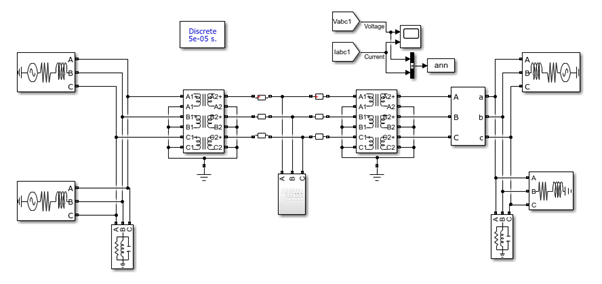

**Latar Belakang**:
Saluran transmisi merupakan tulang punggung sistem tenaga listrik yang bertugas menyalurkan energi dari pembangkit ke pusat beban. Karena infrastrukturnya yang membentang luas di area terbuka, saluran ini sangat rentan terhadap gangguan eksternal maupun internal, seperti petir, pohon tumbang, atau kegagalan isolasi.

Sistem proteksi modern menuntut respons yang tidak hanya cepat tetapi juga sangat akurat (selektif). Kegagalan dalam mengidentifikasi jenis gangguan secara tepat dapat menyebabkan tripping yang tidak perlu atau justru keterlambatan pemutusan arus yang berakibat fatal pada kerusakan trafo dan generator, serta blackout yang meluas.

Sistem tenaga modern yang kompleks memerlukan proteksi yang cepat dan andal. Gangguan harus dideteksi dan diklasifikasikan dengan benar dalam waktu sesingkat mungkin untuk memicu circuit breaker (relay) dan mencegah pemadaman listrik (outage) yang meluas atau kerusakan peralatan.

**Masalah**:
Meskipun relai proteksi digital konvensional sudah canggih, terdapat tantangan spesifik dalam analisis data gangguan:
1.   Kemiripan Pola (Pattern Similarity): Gangguan Tiga Fasa Seimbang (LLL) dan Tiga Fasa ke Tanah (GLLL) memiliki karakteristik arus fase yang sangat mirip, sehingga sulit dibedakan hanya dengan melihat magnitudo arus fasa saja.
2.   Noise & Outlier: Data sensor lapangan seringkali mengandung noise atau lonjakan nilai ekstrem (outlier) yang dapat membingungkan algoritma deteksi standar.
3.   Keterbatasan Model Tunggal: Mengandalkan satu jenis algoritma saja (misal hanya ANN sederhana) seringkali tidak memberikan performa yang konsisten antara bias dan variance, terutama pada dataset yang tidak seimbang (imbalanced dataset).
**Solusi & Pendekatan Teknis**:
Proyek ini mengajukan pendekatan Data-Driven Protection menggunakan metode Hybrid Machine Learning & Deep Learning yang diperkuat dengan Physics-Based Feature Engineering.
Berbeda dengan pendekatan "Black Box" murni, proyek ini mengintegrasikan prinsip fisika kelistrikan ke dalam pemrosesan data:
*   Feature Engineering (Symmetrical Components): Menghitung parameter Zero Sequence / Residual Current ($I_g$) dari data mentah. Fitur ini ditambahkan secara eksplisit untuk mengatasi masalah kemiripan pola antara gangguan LLL dan GLLL.
*   Robust Preprocessing: Menerapkan teknik Winsorizing (Capping) dan Robust Scaler untuk menangani outlier data gangguan tanpa menghapus informasi vital dari lonjakan arus hubung singkat.
*   Deep Learning Optimization: Menggunakan arsitektur Deep Neural Network (DNN) dengan struktur Funneling (256-128-64 neuron), Batch Normalization, dan Dropout untuk stabilitas pelatihan.

**Tujuan**:
Berdasarkan implementasi kode, tujuan spesifik proyek ini adalah:
1.   Klasifikasi 6 Kelas Status: Mengembangkan model yang mampu mengklasifikasikan kondisi sistem menjadi 6 status:
      *   Normal (No Fault)
      *   Line-to-Ground (LG)
      *   Line-to-Line (LL)
      *   Line-to-Line-to-Ground (LLG)
      *   Three-Phase (LLL)
      *   Three-Phase-to-Ground (GLLL)
2.   Komparasi Performa Komprehensif: Membandingkan efektivitas model Deep Learning (TensorFlow) melawan algoritma Machine Learning klasik (SVM, Random Forest, XGBoost, KNN, Classic ANN) untuk menentukan model terbaik.
3.   Analisis Visual Mendalam: Menyediakan evaluasi kinerja tidak hanya berdasarkan akurasi global, tetapi juga melalui:
      *   ROC Curves: Untuk melihat probabilitas deteksi per kelas.
      *   Learning Curves: Untuk mendeteksi overfitting/underfitting.
      *   Delta Accuracy: Mengukur seberapa jauh selisih performa antar model.
      *   Confusion Matrix Heatmap: Untuk melihat detail kesalahan prediksi pada setiap tipe gangguan.

# Deskripsi Data
Data diperoleh dari simulasi sistem tenaga listrik menggunakan MATLAB.

*   Sistem Simulasi: Terdiri dari 4 generator ($11 \times 10^3 V$) yang terletak di ujung saluran transmisi dengan transformator di antaranya.
*   Skenario Gangguan: Gangguan disimulasikan pada titik tengah saluran transmisi.
*   Total Data: $\approx 12.000$ sampel data.
*   Fitur Input (6 Fitur):
    *   Arus 3 Fasa: $I_a, I_b, I_c$
    *   Tegangan 3 Fasa: $V_a, V_b, V_c$
*   Target Output (Label):
    *   Status Gangguan (Ada/Tidak Ada).
    *   Tipe Gangguan (Normal, L-G, L-L, L-L-G, L-L-L).


## Distribusi Data Input dan Target

In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Colab Notebooks/Dataset/01 Electrical Fault Detection and Clasification/classData.csv'

try:
    classData = pd.read_csv(file_path)
except FileNotFoundError:
    print(f"Error: File tidak ditemukan di {file_path}. Cek kembali path-nya.")
    classData = pd.DataFrame(np.random.randn(500, 6), columns=['Ia','Ib','Ic','Va','Vb','Vc'])
    for c in ['G','C','B','A']: classData[c] = np.random.randint(0,2,500)

Mounted at /content/drive


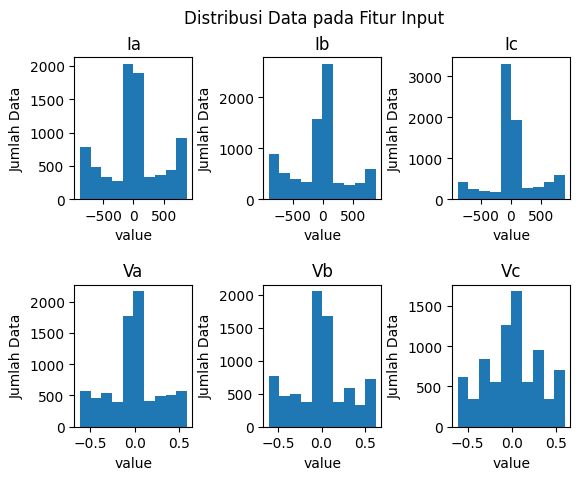

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Show distribution of input features
fig = plt.figure()
gs = fig.add_gridspec(2, 3, hspace=0.6, wspace=0.6)
axs = gs.subplots()
fig.suptitle('Distribusi Data pada Fitur Input')
axs[0, 0].hist(classData["Ia"])
axs[0, 0].set_title('Ia')
axs[0, 1].hist(classData["Ib"])
axs[0, 1].set_title('Ib')
axs[0, 2].hist(classData["Ic"])
axs[0, 2].set_title('Ic')
axs[1, 0].hist(classData["Va"])
axs[1, 0].set_title('Va')
axs[1, 1].hist(classData["Vb"])
axs[1, 1].set_title('Vb')
axs[1, 2].hist(classData["Vc"])
axs[1, 2].set_title('Vc')

for ax in axs.flat:
    ax.set(xlabel='value', ylabel='Jumlah Data')

**Deskripsi Umum**
Grafik tersebut menampilkan 6 histogram, masing-masing mewakili distribusi frekuensi dari 6 fitur input. Sumbu X (value) menunjukkan nilai besaran (Ampere/Volt atau nilai ternormalisasi), dan sumbu Y (Jumlah Data) menunjukkan seberapa sering nilai tersebut muncul dalam dataset.

**Karakteristik Spesifik**
*   Terpusat di Nol (Centering): Semua grafik ($I_a$ sampai $V_c$) memiliki distribusi yang terpusat di angka 0. Ini sangat wajar untuk data sistem tenaga listrik arus bolak-balik (AC), di mana gelombang sinus bergerak dari positif ke negatif dan memiliki nilai rata-rata (mean) mendekati nol.
*   Simetris (Symmetry): Bentuk distribusi terlihat simetris (sisi kiri negatif dan sisi kanan positif memiliki bentuk yang hampir cerminan). Ini menunjukkan bahwa data mencakup siklus positif dan negatif gelombang secara seimbang.
*   Puncak yang Tinggi (High Kurtosis): Terlihat adanya "batang" yang sangat tinggi di tengah (sekitar nilai 0) pada hampir semua grafik. Sebagian besar data berada dalam kondisi normal atau beban rendah di mana nilainya kecil (mendekati nol) dibandingkan dengan saat terjadi gangguan ekstrem. Data gangguan (nilai ekstrem di ujung kiri/kanan) jumlahnya lebih sedikit dibandingkan data normal.

Berdasarkan visualisasi ini, langkah Preprocessing menjadi WAJIB dilakukan, yaitu:
1.   Standard Scaler (Z-score Normalization): Mengubah distribusi sehingga semua fitur (baik $I$ maupun $V$) memiliki rata-rata 0 dan standar deviasi 1.
2.   MinMax Scaler: Memaksa semua data masuk ke rentang -1 sampai 1.








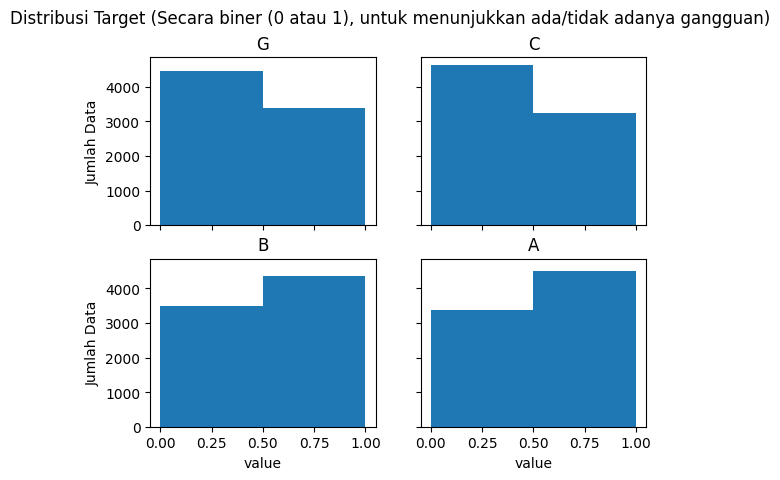

In [3]:
#Show distributions of labels
fig, axs = plt.subplots(2,2, sharex=True, sharey=True)
fig.suptitle('Distribusi Target (Secara biner (0 atau 1), untuk menunjukkan ada/tidak adanya gangguan)')
axs[0, 0].hist(classData["G"], bins=2)
axs[0, 0].set_title('G')
axs[0, 1].hist(classData["C"], bins=2)
axs[0, 1].set_title('C')
axs[1, 0].hist(classData["B"], bins=2)
axs[1, 0].set_title('B')
axs[1, 1].hist(classData["A"], bins=2)
axs[1, 1].set_title('A')

for ax in axs.flat:
    ax.set(xlabel='value', ylabel='Jumlah Data')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

Data ini tegas bersifat biner (bernilai 0 atau 1). Tidak ada nilai pecahan. Ini mengonfirmasi bahwa tugas machine learning yang akan dilakukan adalah Klasifikasi.
Keseimbangan Kelas (Class Balance)
*   Jika kita melihat tinggi batang antara 0 dan 1 pada setiap grafik (G, C, B, A), perbedaannya tidak terlalu ekstrem.
*   Meskipun tidak sempurna 50:50, rasionya terlihat sehat. Pada G dan C: Batang 0 (Normal) terlihat sedikit lebih tinggi daripada batang 1 (Fault).Pada B dan A: Batang 1 (Fault) terlihat sedikit lebih tinggi atau sebanding dengan batang 0. Dataset ini Cukup Seimbang (Balanced).

Dari karakteristik distribusi target ini, ada beberapa keputusan teknis yang harus diambil untuk arsitektur model:
1.   Jenis Permasalahan: Multi-Label Classification Karena targetnya terpisah menjadi G, C, B, A yang masing-masing bisa bernilai 0 atau 1 secara independen (contoh: Gangguan A-B-G berarti A=1, B=1, G=1, C=0), maka ini adalah Multi-label Classification.
2.   Aktivasi Output Layer: WAJIB Sigmoid. Gunakan Sigmoid pada 4 neuron output terakhir. Ini memungkinkan model memberikan probabilitas tinggi pada A dan B secara bersamaan jika terjadi gangguan antar fasa A-B.
3.   Tidak Perlu "Resampling" Berat Karena datanya sudah cukup seimbang, tidak perlu melakukan teknik penanganan imbalanced data yang rumit seperti SMOTE (Synthetic Minority Over-sampling Technique) atau memberikan class weights yang ekstrem.



## Korelasi Data Input

# Environmental Setup & configuration
Bagian ini menyiapkan library, mematikan warning, dan mengatur palet warna agar konsisten di semua grafik.

In [4]:
# Environmental Setup & configuration
import os
# Set backend Keras agar stabil
os.environ["KERAS_BACKEND"] = "tensorflow"

import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import math
from itertools import cycle

# Scikit-Learn Ecosystem
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import RobustScaler, label_binarize, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, silhouette_score
from sklearn.utils import class_weight
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Deep Learning (TensorFlow/Keras)
import tensorflow as tf
import keras
from tensorflow import keras
from keras import layers, callbacks, optimizers

# ML Models
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# --- KONFIGURASI GLOBAL ---
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
np.random.seed(42)
tf.random.set_seed(42)

# Palet Warna Model
MODEL_COLORS = {
    'Deep Learning (Optimized)': '#1f77b4', 'Classic ANN': '#ff7f0e',
    'Random Forest': '#2ca02c', 'XGBoost': '#d62728',
    'SVM (RBF)': '#9467bd', 'KNN': '#8c564b'
}

print("Environment Setup Complete.")

Environment Setup Complete.


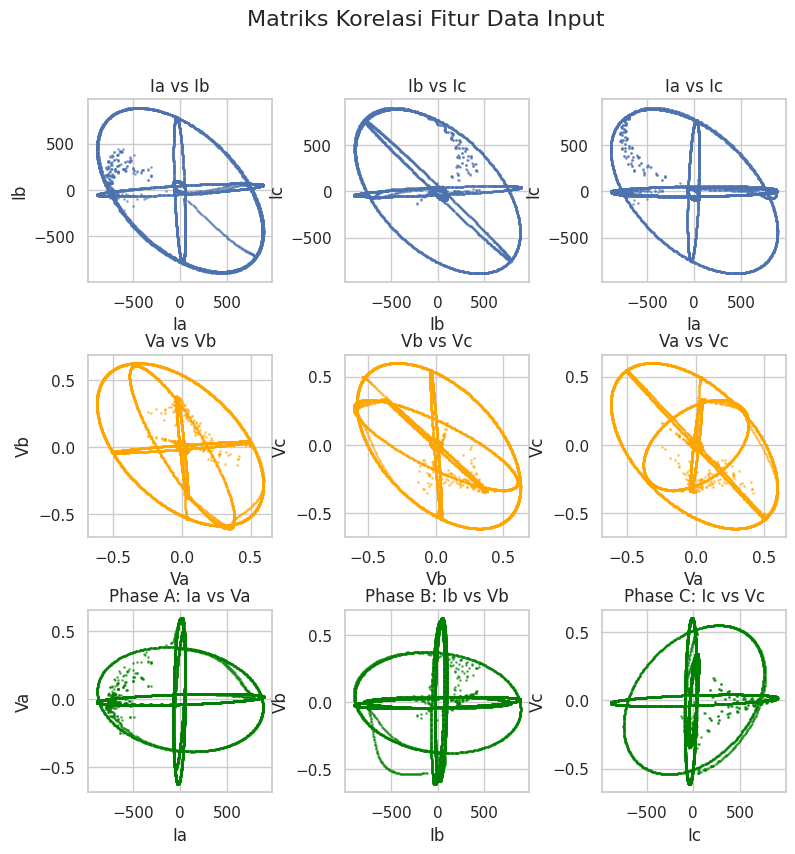

In [5]:
# Mengatur ukuran figure agar grid 3x3 terlihat jelas
fig = plt.figure(figsize=(9, 9))

# Membuat grid 3 baris x 3 kolom
gs = fig.add_gridspec(3, 3, hspace=0.4, wspace=0.4)
axs = gs.subplots()

fig.suptitle('Matriks Korelasi Fitur Data Input', fontsize=16)

# --- BARIS 1: Hubungan Arus Antar Fasa (Current Inter-phase) ---
# 1. Ia vs Ib
axs[0, 0].scatter(classData["Ia"], classData["Ib"], s=1, alpha=0.5)
axs[0, 0].set_title('Ia vs Ib')
axs[0, 0].set(xlabel='Ia', ylabel='Ib')

# 2. Ib vs Ic
axs[0, 1].scatter(classData["Ib"], classData["Ic"], s=1, alpha=0.5)
axs[0, 1].set_title('Ib vs Ic')
axs[0, 1].set(xlabel='Ib', ylabel='Ic')

# 3. Ia vs Ic
axs[0, 2].scatter(classData["Ia"], classData["Ic"], s=1, alpha=0.5)
axs[0, 2].set_title('Ia vs Ic')
axs[0, 2].set(xlabel='Ia', ylabel='Ic')

# --- BARIS 2: Hubungan Tegangan Antar Fasa (Voltage Inter-phase) ---
# 4. Va vs Vb
axs[1, 0].scatter(classData["Va"], classData["Vb"], s=1, c='orange', alpha=0.5)
axs[1, 0].set_title('Va vs Vb')
axs[1, 0].set(xlabel='Va', ylabel='Vb')

# 5. Vb vs Vc
axs[1, 1].scatter(classData["Vb"], classData["Vc"], s=1, c='orange', alpha=0.5)
axs[1, 1].set_title('Vb vs Vc')
axs[1, 1].set(xlabel='Vb', ylabel='Vc')

# 6. Va vs Vc
axs[1, 2].scatter(classData["Va"], classData["Vc"], s=1, c='orange', alpha=0.5)
axs[1, 2].set_title('Va vs Vc')
axs[1, 2].set(xlabel='Va', ylabel='Vc')

# --- BARIS 3: Arus vs Tegangan per Fasa (Impedance View) ---
# 7. Phase A (Ia vs Va)
axs[2, 0].scatter(classData["Ia"], classData["Va"], s=1, c='green', alpha=0.5)
axs[2, 0].set_title('Phase A: Ia vs Va')
axs[2, 0].set(xlabel='Ia', ylabel='Va')

# 8. Phase B (Ib vs Vb)
axs[2, 1].scatter(classData["Ib"], classData["Vb"], s=1, c='green', alpha=0.5)
axs[2, 1].set_title('Phase B: Ib vs Vb')
axs[2, 1].set(xlabel='Ib', ylabel='Vb')

# 9. Phase C (Ic vs Vc)
axs[2, 2].scatter(classData["Ic"], classData["Vc"], s=1, c='green', alpha=0.5)
axs[2, 2].set_title('Phase C: Ic vs Vc')
axs[2, 2].set(xlabel='Ic', ylabel='Vc')

plt.show()

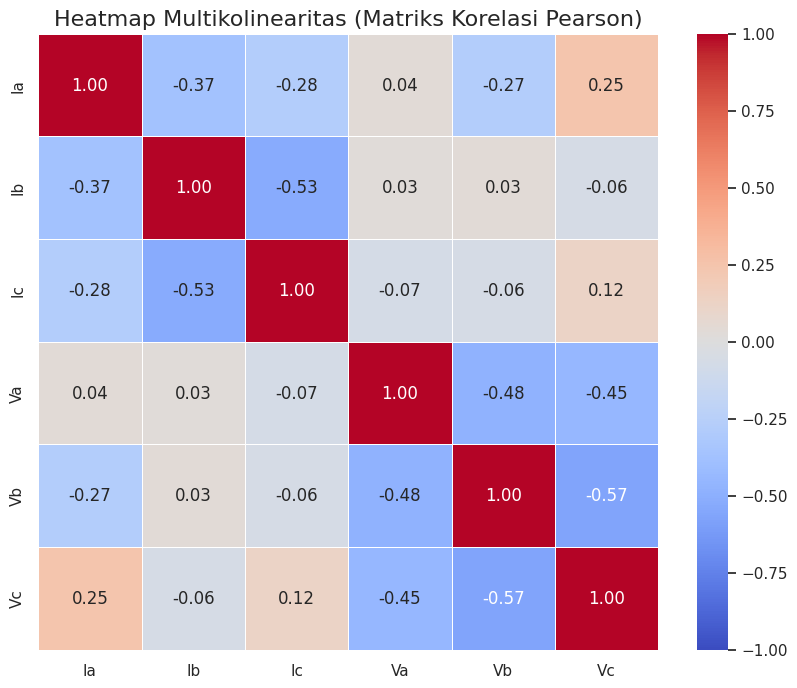

In [6]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

input_features = ['Ia', 'Ib', 'Ic', 'Va', 'Vb', 'Vc']
correlation_matrix = classData[input_features].corr()

# 2. Membuat Plot Heatmap
plt.figure(figsize=(10, 8))

# Pengaturan Heatmap:
# annot=True : Menampilkan angka korelasi di dalam kotak
# cmap='coolwarm' : Warna (Merah = Positif Kuat, Biru = Negatif Kuat)
# fmt=".2f" : Format angka 2 desimal
# vmin=-1, vmax=1 : Mengunci skala warna dari -1 hingga 1
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='coolwarm',
            fmt=".2f",
            linewidths=0.5,
            vmin=-1,
            vmax=1)

plt.title('Heatmap Multikolinearitas (Matriks Korelasi Pearson)', fontsize=16)
plt.show()

# Data Preprocessing

In [7]:
# --- SECTION 2: DATA PIPELINE ---
class DataPipeline:
    def __init__(self):
        self.scaler = RobustScaler()
        # Mapping target klasifikasi
        self.known_faults = {
            (0,0,0,0): 0, # Normal
            (1,0,0,1): 1, # LG (Line-Ground)
            (0,1,1,0): 2, # LL (Line-Line)
            (1,0,1,1): 3, # LLG
            (0,1,1,1): 4, # LLL
            (1,1,1,1): 5  # LLLG
        }
        self.feature_names = ['Ia', 'Ib', 'Ic', 'Va', 'Vb', 'Vc', 'Ig_mag', 'V_mean', 'I_mean']

    def process(self, file_path):
        # A. Load / Generate Data Dummy jika file tidak ada
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            print(f"[INFO] Dataset dimuat: {len(df)} baris.")
        else:
            print("[WARN] File tidak ditemukan. Menggunakan DUMMY DATA untuk demonstrasi.")
            df = pd.DataFrame(np.random.randn(2000, 6)*100, columns=['Ia','Ib','Ic','Va','Vb','Vc'])
            for c in ['G','C','B','A']: df[c] = np.random.randint(0,2,2000)
            # Inject pola pasti agar visualisasi masuk akal
            patterns = [[0,0,0,0], [1,0,0,1], [0,1,1,0], [1,0,1,1], [0,1,1,1], [1,1,1,1]]
            for i, p in enumerate(patterns): df.loc[i, ['G','C','B','A']] = p

        # B. Feature Engineering
        # Menambahkan fitur fisik kelistrikan
        df['Ig_mag'] = (df['Ia'] + df['Ib'] + df['Ic']).abs()
        df['V_mean'] = (df['Va'] + df['Vb'] + df['Vc']) / 3
        df['I_mean'] = (df['Ia'] + df['Ib'] + df['Ic']) / 3

        # C. Outlier Capping (Mengatasi data noise sensor ekstrem)
        for col in ['Ia','Ib','Ic','Va','Vb','Vc']:
            Q1 = df[col].quantile(0.25); Q3 = df[col].quantile(0.75); IQR = Q3 - Q1
            lower, upper = Q1 - (3.0 * IQR), Q3 + (3.0 * IQR)
            df[col] = np.clip(df[col], lower, upper)

        # D. Target Mapping
        df['Fault_Type'] = df[['G', 'C', 'B', 'A']].apply(tuple, axis=1).map(self.known_faults)
        df.dropna(subset=['Fault_Type'], inplace=True)

        y = df['Fault_Type'].astype(int).values
        X = df[self.feature_names].values

        # E. Split & Scale
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=42, stratify=y)
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        return X_train_scaled, X_test_scaled, y_train, y_test, self.feature_names

# --- EKSEKUSI PIPELINE ---
# Ganti path di bawah sesuai lokasi file Anda di Google Drive
FILE_PATH = '/content/drive/MyDrive/Colab Notebooks/Dataset/01 Electrical Fault Detection and Clasification/classData.csv'

pipeline = DataPipeline()
X_train, X_test, y_train, y_test, feature_names = pipeline.process(FILE_PATH)

print(f"Data Siap. Dimensi Training: {X_train.shape}")

[INFO] Dataset dimuat: 7861 baris.
Data Siap. Dimensi Training: (3144, 9)


## Visualisasi Struktur Data (Boxplot)

Generating Boxplot...


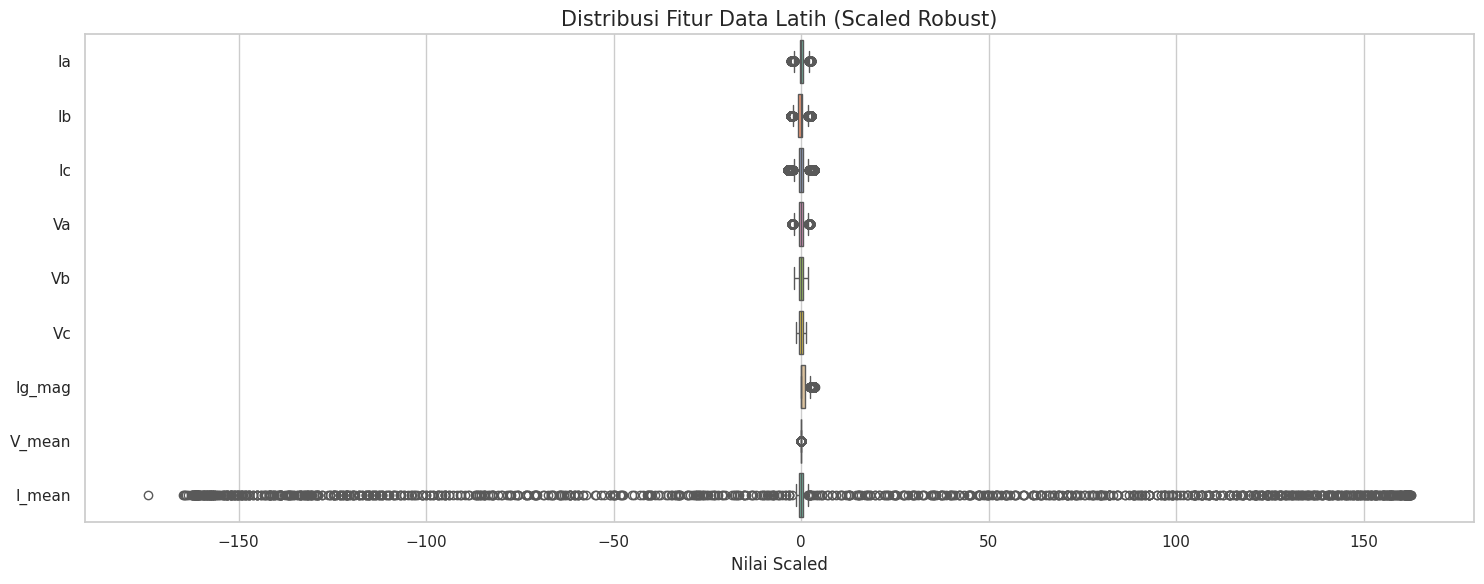

In [8]:
# Konversi ke DataFrame untuk memudahkan plotting seaborn
X_train_df = pd.DataFrame(X_train, columns=feature_names)

# --- 1. Visualisasi Distribusi Data (Boxplot) ---
print("Generating Boxplot...")
plt.figure(figsize=(15, 6))
sns.boxplot(data=X_train_df, orient="h", palette="Set2")
plt.title("Distribusi Fitur Data Latih (Scaled Robust)", fontsize=15)
plt.xlabel("Nilai Scaled")
plt.tight_layout()
plt.show()

Generating KDE Plot...


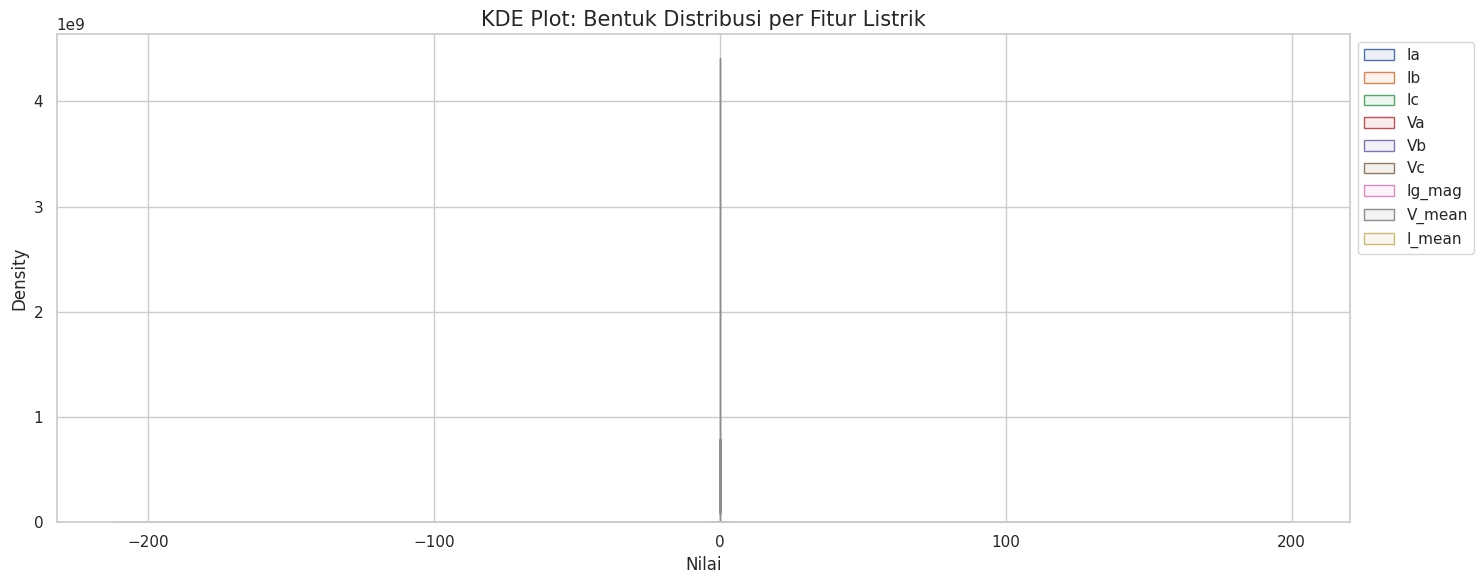

In [9]:
# --- 2. Visualisasi KDE Plot (Bentuk Distribusi) ---
print("Generating KDE Plot...")
plt.figure(figsize=(15, 6))
for col in X_train_df.columns:
    sns.kdeplot(X_train_df[col], fill=True, alpha=0.1, label=col)
plt.title("KDE Plot: Bentuk Distribusi per Fitur Listrik", fontsize=15)
plt.xlabel("Nilai")
plt.ylabel("Density")
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [10]:
# --- 3. Visualisasi 3D PCA (Separability) ---
import plotly.express as px
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

print("Generating Professional Interactive 3D PCA...")

# 1. Pastikan labels_map terdefinisi
labels_map = {0:'Normal', 1:'LG', 2:'LL', 3:'LLG', 4:'LLL', 5:'GLLL'}

# 2. Hitung PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_train)

# 3. Hitung Detail Varians
var_ratio = pca.explained_variance_ratio_
total_var = np.sum(var_ratio) * 100

# Siapkan label sumbu
axis_labels = {
    'x': f'PC 1 ({var_ratio[0]:.1%} Variance)',
    'y': f'PC 2 ({var_ratio[1]:.1%} Variance)',
    'z': f'PC 3 ({var_ratio[2]:.1%} Variance)'
}

# 4. Persiapan Data untuk Plotly (FIX ERROR DISINI)
# Kita paksa konversi ke integer 'int(val)' agar cocok dengan key dictionary
try:
    y_train_text = [labels_map[int(val)] for val in y_train]
except Exception as e:
    print(f"Warning: Gagal mapping label. Menggunakan label angka asli. Error: {e}")
    y_train_text = y_train

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])
pca_df['Fault Type'] = y_train_text

# 5. Membuat Plot Interaktif
fig = px.scatter_3d(
    pca_df, x='PC1', y='PC2', z='PC3',
    color='Fault Type',
    title=f"3D PCA Projection: Analisis Keterpisahan Kelas<br>(Total Explained Variance: {total_var:.1f}%)",
    labels={'PC1': axis_labels['x'], 'PC2': axis_labels['y'], 'PC3': axis_labels['z']},
    color_discrete_sequence=px.colors.qualitative.Bold,
    opacity=0.8,
    width=1000, height=700
)

# Kustomisasi Visual
fig.update_traces(marker=dict(size=5, line=dict(width=0.5, color='DarkSlateGrey')))
fig.update_layout(
    legend_title_text='Jenis Gangguan',
    margin=dict(l=0, r=0, b=0, t=50),
    scene=dict(
        xaxis=dict(backgroundcolor="white", gridcolor="lightgrey", showbackground=True),
        yaxis=dict(backgroundcolor="white", gridcolor="lightgrey", showbackground=True),
        zaxis=dict(backgroundcolor="white", gridcolor="lightgrey", showbackground=True),
    )
)

fig.show()

Generating Professional Interactive 3D PCA...


## Hierarki Clustering (Unsupervised Non-Linear Analysis)

Generating Dendrogram...


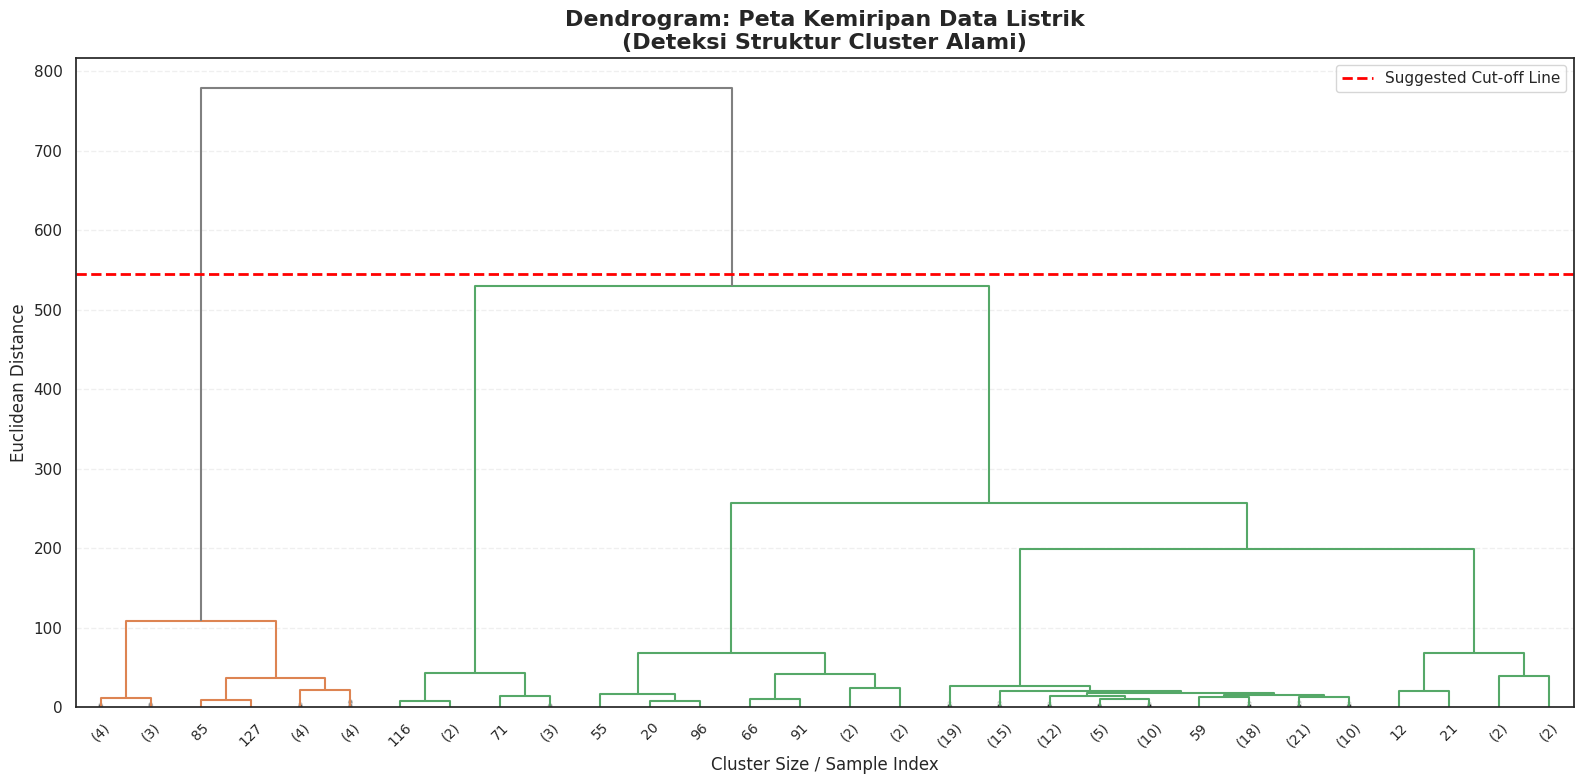

In [11]:
# ==============================================================================
# 4.1. HIERARKI CLUSTERING: DENDROGRAM VISUALIZATION
# ==============================================================================
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

print("Generating Dendrogram...")
sns.set_style("white")

# 1. Siapkan Data Sample (Agar visualisasi tidak berat)
# Mengambil 150 sampel acak dari data training
X_sample_viz = pd.DataFrame(X_train, columns=feature_names).sample(150, random_state=42)

# 2. Hitung Linkage (Metode Ward)
Z = linkage(X_sample_viz, method='ward')

# 3. Setup Plotting
plt.figure(figsize=(16, 8))

# Hitung threshold warna otomatis (70% dari jarak maksimum)
max_d = max(Z[:, 2])
color_threshold = 0.7 * max_d

# 4. Gambar Dendrogram
dendro = dendrogram(
    Z,
    truncate_mode='lastp', p=30, leaf_rotation=45., leaf_font_size=10.,
    show_contracted=True,
    color_threshold=color_threshold, above_threshold_color='grey'
)

# 5. Garis Cut-off
plt.axhline(y=color_threshold, c='red', lw=2, linestyle='--', label='Suggested Cut-off Line')

plt.title('Dendrogram: Peta Kemiripan Data Listrik\n(Deteksi Struktur Cluster Alami)', fontsize=16, fontweight='bold')
plt.xlabel("Cluster Size / Sample Index"); plt.ylabel("Euclidean Distance")
plt.legend(loc='best'); plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

Calculating Silhouette Scores...
   > k=2: Score = 0.7634
   > k=3: Score = 0.8413
   > k=4: Score = 0.8362
   > k=5: Score = 0.8311
   > k=6: Score = 0.8280


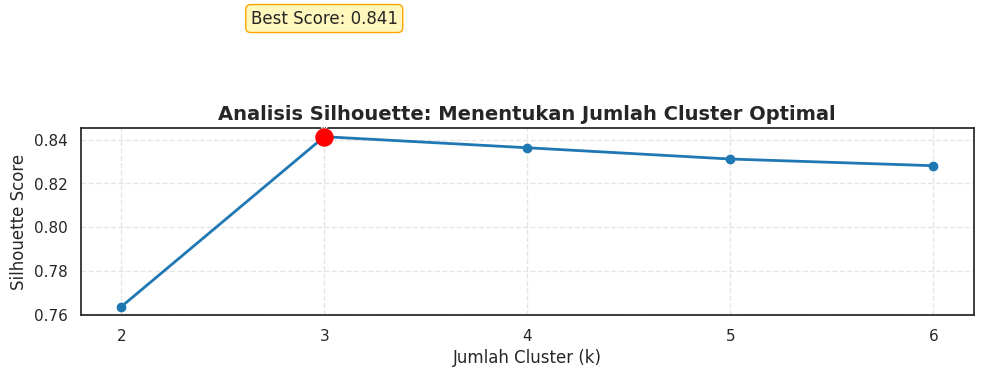


[HASIL ANALISIS] Jumlah klaster paling optimal adalah: 3


In [12]:
# ==============================================================================
# 4.2. UNSUPERVISED METRICS: SILHOUETTE SCORE ANALYSIS
# ==============================================================================
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import numpy as np

print("Calculating Silhouette Scores...")

range_n_clusters = [2, 3, 4, 5, 6]
silhouette_avg = []

# Gunakan sample data untuk perhitungan skor (max 1000 data)
X_sil_calc = pd.DataFrame(X_train, columns=feature_names).sample(min(1000, len(X_train)), random_state=42)

# 1. Loop hitung skor
for k in range_n_clusters:
    clusterer = AgglomerativeClustering(n_clusters=k)
    cluster_labels = clusterer.fit_predict(X_sil_calc)
    score = silhouette_score(X_sil_calc, cluster_labels)
    silhouette_avg.append(score)
    print(f"   > k={k}: Score = {score:.4f}")

# 2. Cari pemenang (best_k)
best_score = max(silhouette_avg)
best_k = range_n_clusters[silhouette_avg.index(best_score)]

# 3. Plot Visualisasi
plt.figure(figsize=(10, 5))
plt.plot(range_n_clusters, silhouette_avg, marker='o', linestyle='-', color='#1f77b4', linewidth=2)
plt.scatter(best_k, best_score, color='red', s=150, zorder=5, label=f'Optimal k={best_k}')
plt.annotate(f'Best Score: {best_score:.3f}', xy=(best_k, best_score), xytext=(best_k, best_score + 0.05),
             ha='center', va='bottom', bbox=dict(boxstyle='round,pad=0.3', fc='#fff7bc', alpha=1.0, edgecolor='orange'),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.title("Analisis Silhouette: Menentukan Jumlah Cluster Optimal", fontsize=14, fontweight='bold')
plt.xlabel("Jumlah Cluster (k)"); plt.ylabel("Silhouette Score")
plt.xticks(range_n_clusters); plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout(); plt.show()

print(f"\n[HASIL ANALISIS] Jumlah klaster paling optimal adalah: {best_k}")

Generating Insight Report for k=3 Clusters...


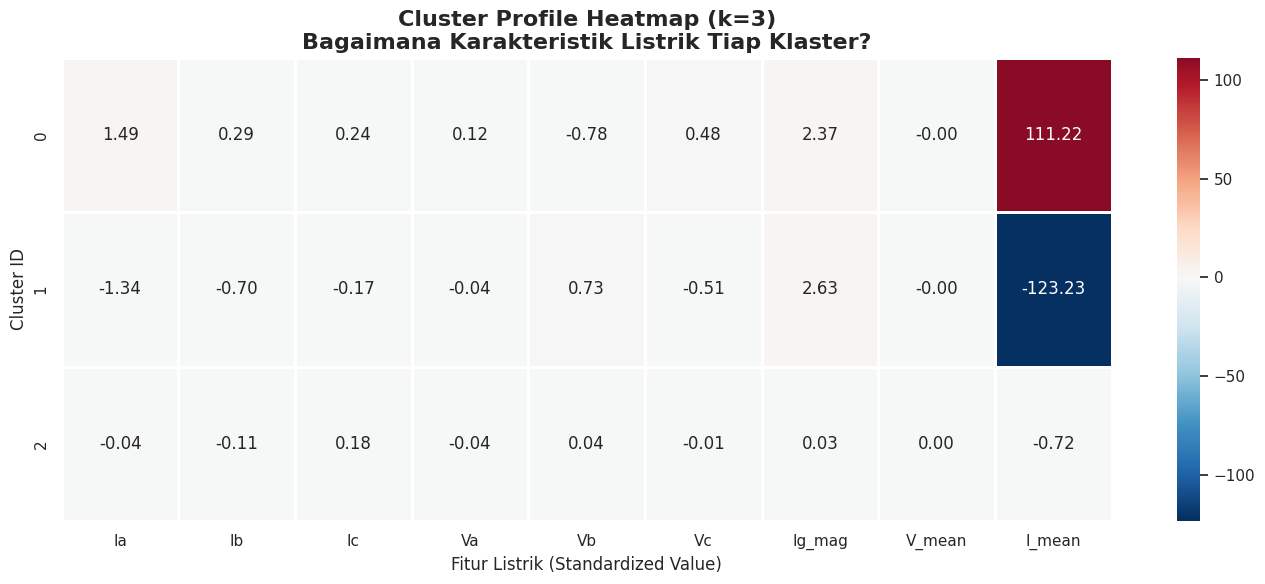


                         CLUSTER INTERPRETATION REPORT                          

[CLUSTER 0] Characteristics:
  📈 Dominan Tinggi pada: Ia, Ig_mag, I_mean
     (Interpretasi: Nilai Ia, Ig_mag, I_mean jauh di atas rata-rata normal)
  📉 Dominan Rendah pada: Vb
     (Interpretasi: Nilai Vb drop/sag di bawah rata-rata)

[CLUSTER 1] Characteristics:
  📈 Dominan Tinggi pada: Vb, Ig_mag
     (Interpretasi: Nilai Vb, Ig_mag jauh di atas rata-rata normal)
  📉 Dominan Rendah pada: Ia, Ib, Vc, I_mean
     (Interpretasi: Nilai Ia, Ib, Vc, I_mean drop/sag di bawah rata-rata)

[CLUSTER 2] Characteristics:
  📉 Dominan Rendah pada: I_mean
     (Interpretasi: Nilai I_mean drop/sag di bawah rata-rata)

[REKOMENDASI FITUR]
Fitur dengan perbedaan warna paling kontras di Heatmap adalah fitur terpenting untuk membedakan klaster.
Biasanya dalam gangguan listrik: Arus (Ia,Ib,Ic) akan MERAH (Tinggi) dan Tegangan (Va,Vb,Vc) akan BIRU (Drop).


In [13]:
# ==============================================================================
# 4.3. CLUSTER INSIGHT REPORT: FEATURE ANALYSIS
# ==============================================================================
# Tujuan: Menjawab "Kenapa data dikelompokkan seperti ini?" dan "Fitur apa yang membedakannya?"

print(f"Generating Insight Report for k={best_k} Clusters...")

# 1. Fit Model Clustering Final (dengan best_k dari langkah sebelumnya)
final_cluster_model = AgglomerativeClustering(n_clusters=best_k)
# Gunakan data sample yg sama atau seluruh data training (disarankan sample jika data besar)
X_analysis = pd.DataFrame(X_train, columns=feature_names)
cluster_labels = final_cluster_model.fit_predict(X_train) # Prediksi label klaster (0, 1, dst)

# 2. Gabungkan Fitur dengan Label Klaster
X_analysis['Cluster_Label'] = cluster_labels

# 3. Hitung Rata-rata Fitur per Klaster (Centroids)
cluster_means = X_analysis.groupby('Cluster_Label').mean()

# 4. Visualisasi Heatmap Karakteristik Klaster
plt.figure(figsize=(14, 6))
# Gunakan cmap 'RdBu_r' (Merah=Tinggi/Positif, Biru=Rendah/Negatif) karena data sudah di-scale
sns.heatmap(cluster_means, annot=True, fmt=".2f", cmap="RdBu_r", center=0, linewidths=1, linecolor='white')

plt.title(f"Cluster Profile Heatmap (k={best_k})\nBagaimana Karakteristik Listrik Tiap Klaster?", fontsize=16, fontweight='bold')
plt.ylabel("Cluster ID", fontsize=12)
plt.xlabel("Fitur Listrik (Standardized Value)", fontsize=12)
plt.tight_layout()
plt.show()

# 5. Interpretasi Teks Otomatis (Rekomendasi Fitur)
print("\n" + "="*80)
print(f"{'CLUSTER INTERPRETATION REPORT':^80}")
print("="*80)

# Analisis sederhana berdasarkan nilai rata-rata tertinggi/terendah
for cluster_id in range(best_k):
    print(f"\n[CLUSTER {cluster_id}] Characteristics:")

    # Ambil data rata-rata baris ini
    row = cluster_means.loc[cluster_id]

    # Cari fitur yang sangat menonjol (nilai absolut > 0.5)
    high_features = row[row > 0.5].index.tolist()
    low_features = row[row < -0.5].index.tolist()

    if len(high_features) > 0:
        print(f"  📈 Dominan Tinggi pada: {', '.join(high_features)}")
        print(f"     (Interpretasi: Nilai {', '.join(high_features)} jauh di atas rata-rata normal)")

    if len(low_features) > 0:
        print(f"  📉 Dominan Rendah pada: {', '.join(low_features)}")
        print(f"     (Interpretasi: Nilai {', '.join(low_features)} drop/sag di bawah rata-rata)")

    if len(high_features) == 0 and len(low_features) == 0:
        print("  ⚖️  Karakteristik: Rata-rata (Kemungkinan kondisi Normal atau beban seimbang)")

print("\n[REKOMENDASI FITUR]")
print("Fitur dengan perbedaan warna paling kontras di Heatmap adalah fitur terpenting untuk membedakan klaster.")
print("Biasanya dalam gangguan listrik: Arus (Ia,Ib,Ic) akan MERAH (Tinggi) dan Tegangan (Va,Vb,Vc) akan BIRU (Drop).")

*   Klaster 0 merepresentasikan kondisi Gangguan Berat (High Current Fault) di mana arus melonjak drastis.
*   Klaster 1 Ini adalah kebalikan dari Cluster 0. Nilai arusnya sangat rendah dibandingkan rata-rata global data.
*   Klaster 2 Kondisi Stabil/Normal (Balance).




# Definisi Model: Deep Learning & Machine Learning

In [14]:
class RobustDLWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim=None, num_classes=6, epochs=100, batch_size=32):
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = None
        self.history_ = None
        self.classes_ = np.arange(num_classes)
        self._estimator_type = "classifier"

    def fit(self, X, y):
        keras.backend.clear_session()
        if self.input_dim is None: self.input_dim = X.shape[1]

        # Arsitektur Neural Network
        inputs = keras.Input(shape=(self.input_dim,))
        x = layers.Dense(128)(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Dropout(0.3)(x) # Mencegah Overfitting

        x = layers.Dense(64)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Dropout(0.2)(x)

        outputs = layers.Dense(self.num_classes, activation='softmax')(x)

        self.model = keras.Model(inputs=inputs, outputs=outputs, name="Fault_DNN")
        self.model.compile(optimizer=optimizers.Adam(0.001),
                           loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        # Penanganan Imbalanced Data
        classes = np.unique(y)
        weights = class_weight.compute_class_weight('balanced', classes=classes, y=y)
        cw_dict = dict(zip(classes, weights))

        cbs = [callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]

        print(f"[Deep Learning] Training started ({self.epochs} Epochs)...")
        self.history_ = self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size,
                                       validation_split=0.2, callbacks=cbs, class_weight=cw_dict, verbose=0)
        self._plot_history()
        return self

    def predict(self, X):
        return np.argmax(self.model.predict(X, verbose=0), axis=1)

    def predict_proba(self, X):
        return self.model.predict(X, verbose=0)

    def _plot_history(self):
        if self.history_ is None: return
        hist = self.history_.history
        fig, ax = plt.subplots(1, 2, figsize=(14, 4))
        ax[0].plot(hist['loss'], label='Train'); ax[0].plot(hist['val_loss'], label='Val')
        ax[0].set_title('DL Training Loss'); ax[0].legend()
        ax[1].plot(hist['accuracy'], label='Train'); ax[1].plot(hist['val_accuracy'], label='Val')
        ax[1].set_title('DL Training Accuracy'); ax[1].legend()
        plt.show()

# --- INISIALISASI MODEL ---
# 1. Deep Learning
dl_model = RobustDLWrapper(input_dim=X_train.shape[1])

# 2. Machine Learning Klasik
estimators = {
    "Deep Learning (Optimized)": dl_model,
    "Classic ANN": MLPClassifier(max_iter=1000, hidden_layer_sizes=(100,60)),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    "SVM (RBF)": SVC(C=100, gamma='scale', probability=True),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

# Training Model

Mulai Pelatihan Model dengan Visualisasi Real-time...

🔄 SEDANG MELATIH: DEEP LEARNING (OPTIMIZED)...
[Deep Learning] Training started (100 Epochs)...


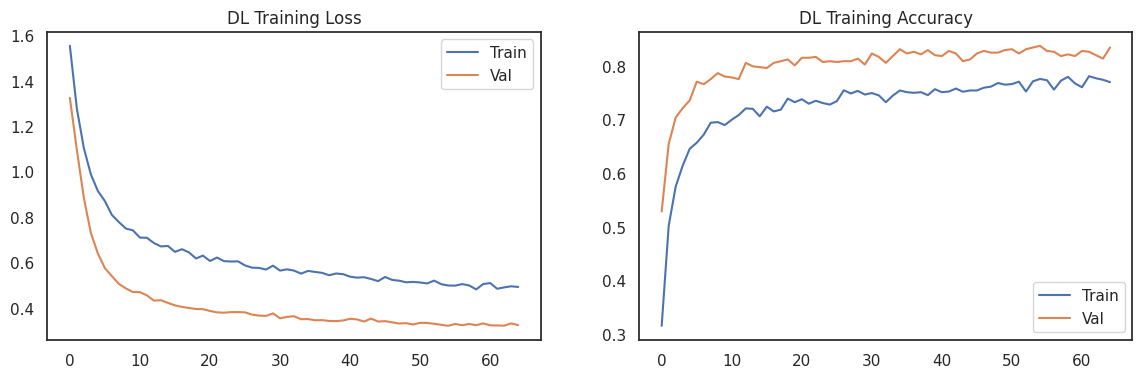

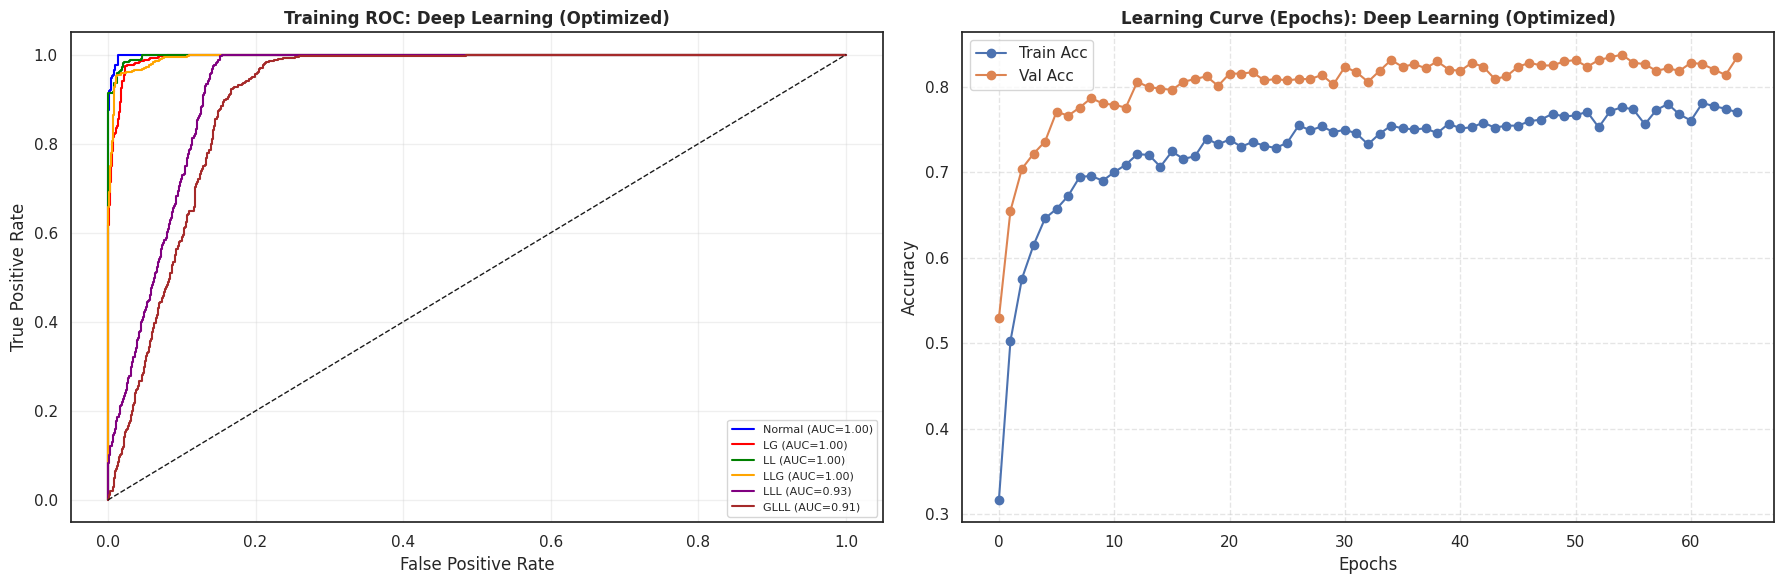


🔄 SEDANG MELATIH: CLASSIC ANN...


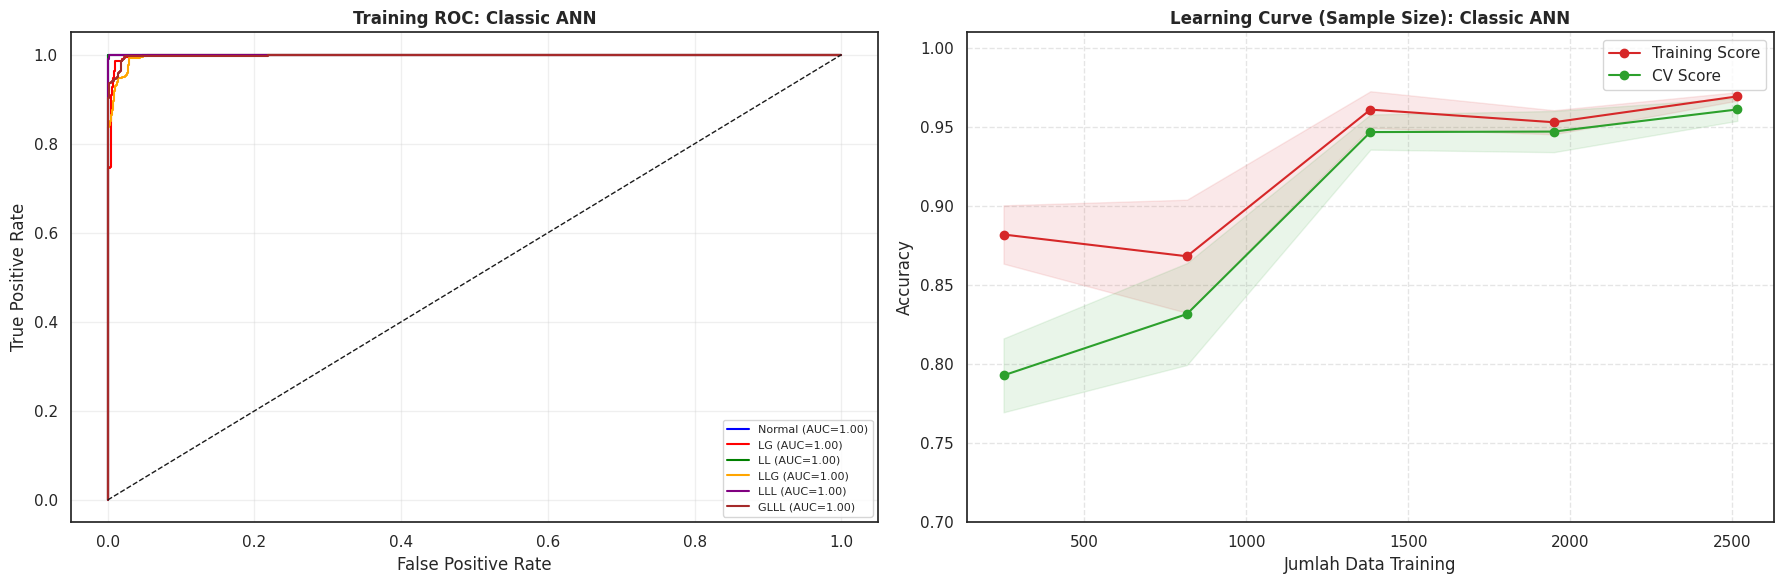


🔄 SEDANG MELATIH: RANDOM FOREST...


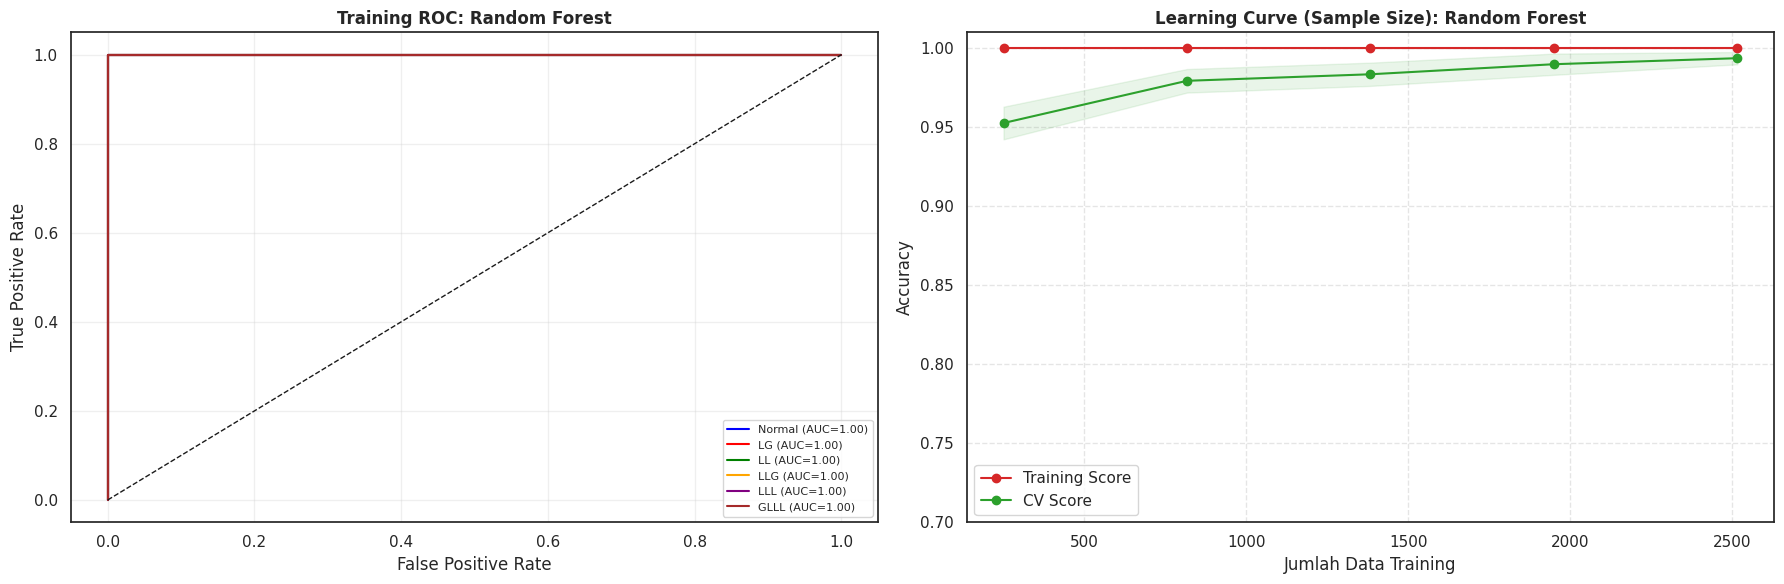


🔄 SEDANG MELATIH: XGBOOST...


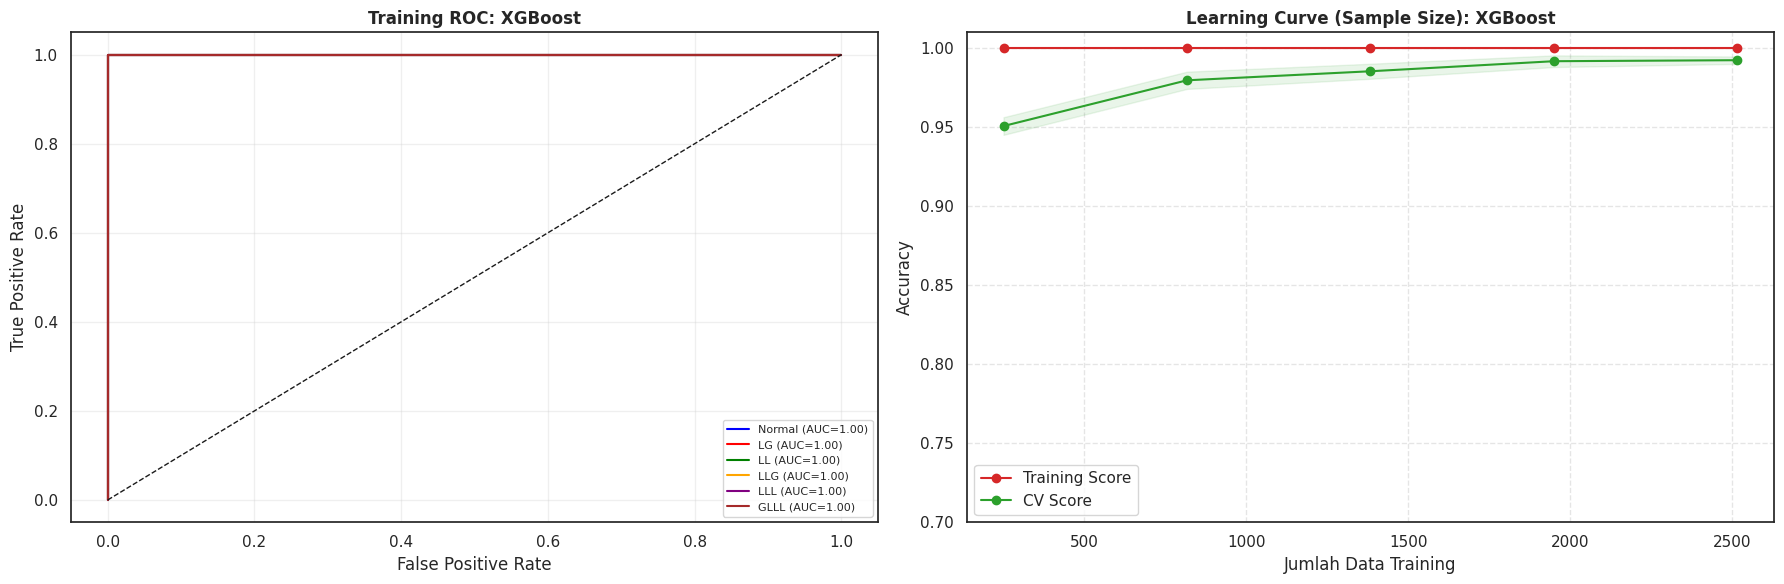


🔄 SEDANG MELATIH: SVM (RBF)...


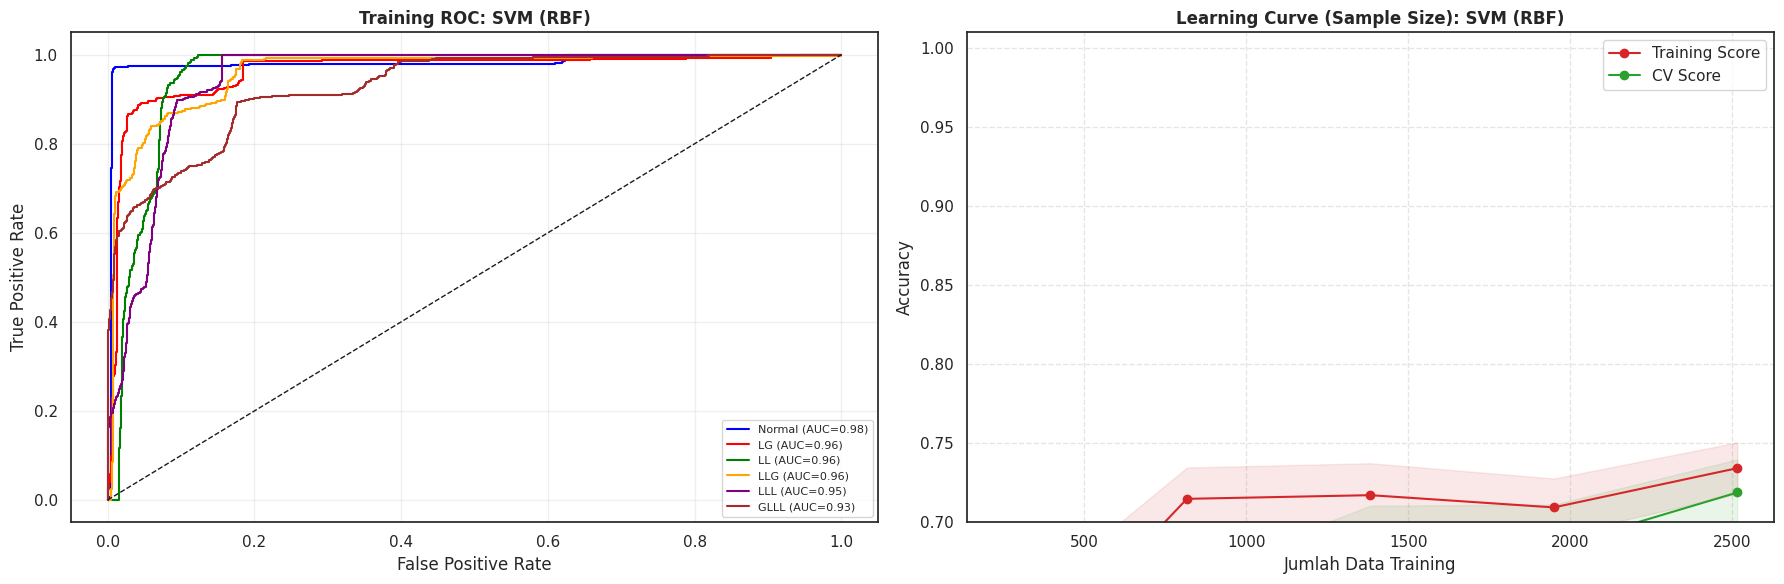


🔄 SEDANG MELATIH: KNN...


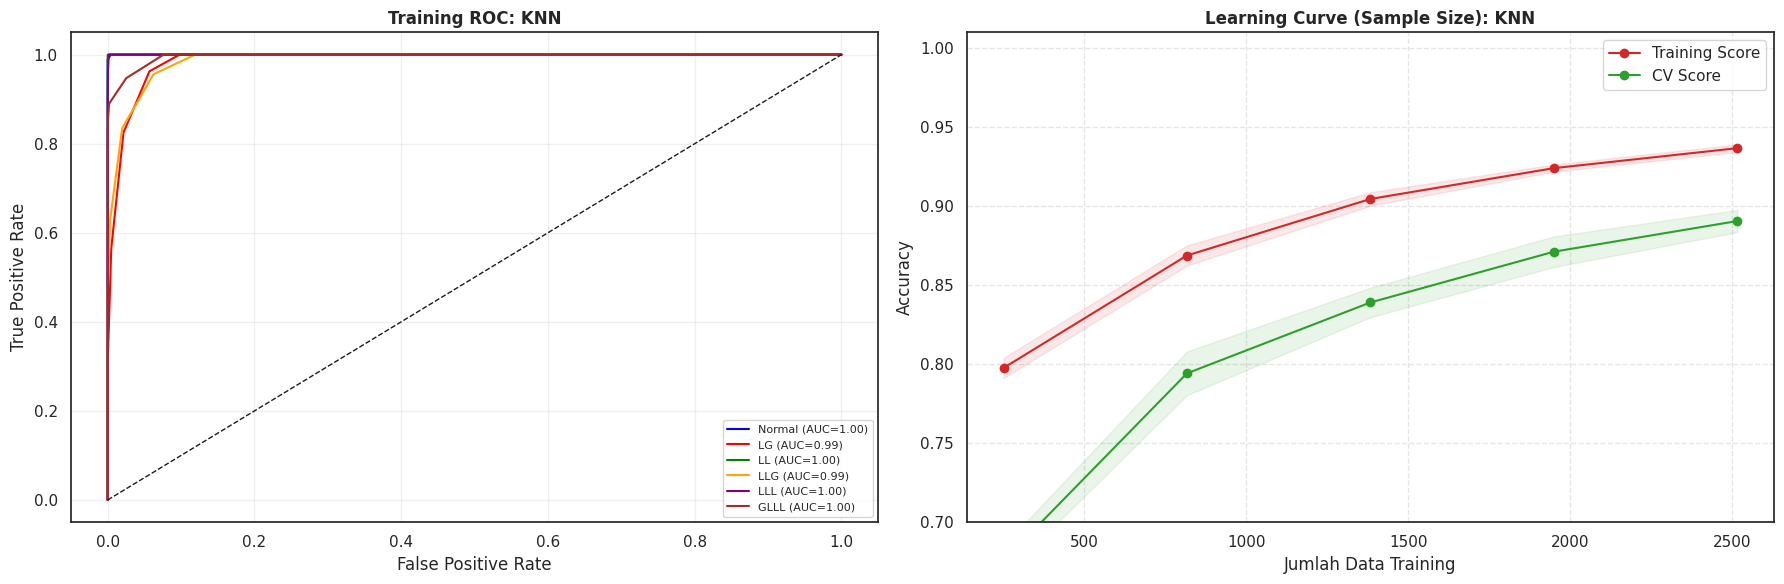


✅ Semua model selesai dilatih.


In [15]:
# ==============================================================================
# 5. TRAINING MODEL & REAL-TIME VISUALIZATION (ROC TRAIN + LEARNING CURVE)
# ==============================================================================
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

def visualize_training_performance(model, model_name, X, y, is_deep_learning=False, dl_history=None):
    """
    Menampilkan visualisasi 2 kolom:
    Kiri: ROC Curve pada Data Training (Seberapa baik model menghapal/fit data latih)
    Kanan: Learning Curve (Analisis Overfitting/Underfitting)
    """
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # --- 1. ROC CURVE (TRAINING DATA) ---
    ax_roc = axes[0]
    n_classes = 6
    y_bin = label_binarize(y, classes=np.arange(n_classes))

    # Mendapatkan probabilitas
    try:
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X)
        else:
            y_score = model.decision_function(X)
    except:
        ax_roc.text(0.5, 0.5, "Probabilitas tidak tersedia", ha='center')
        return

    colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown'])
    labels_map = {0:'Normal', 1:'LG', 2:'LL', 3:'LLG', 4:'LLL', 5:'GLLL'}

    for i, color in zip(range(n_classes), colors):
        if y_score.ndim > 1: # Multiclass logic
             fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
        else:
             fpr, tpr, _ = roc_curve(y_bin[:, i], y_score)

        roc_auc = auc(fpr, tpr)
        ax_roc.plot(fpr, tpr, color=color, lw=1.5, label=f'{labels_map[i]} (AUC={roc_auc:.2f})')

    ax_roc.plot([0, 1], [0, 1], 'k--', lw=1)
    ax_roc.set_title(f"Training ROC: {model_name}", fontweight='bold')
    ax_roc.set_xlabel('False Positive Rate')
    ax_roc.set_ylabel('True Positive Rate')
    ax_roc.legend(loc="lower right", fontsize=8)
    ax_roc.grid(True, alpha=0.3)

    # --- 2. LEARNING CURVE ---
    ax_lc = axes[1]

    if is_deep_learning and dl_history is not None:
        # Khusus Deep Learning: Gunakan History Epoch (Lebih cepat & relevan)
        hist = dl_history.history
        ax_lc.plot(hist['accuracy'], label='Train Acc', marker='o')
        ax_lc.plot(hist['val_accuracy'], label='Val Acc', marker='o')
        ax_lc.set_title(f"Learning Curve (Epochs): {model_name}", fontweight='bold')
        ax_lc.set_xlabel("Epochs")
        ax_lc.set_ylabel("Accuracy")
    else:
        # Khusus ML Klasik: Gunakan Cross-Validation Learning Curve
        # (Training Size vs Accuracy)
        train_sizes, train_scores, test_scores = learning_curve(
            model, X, y, cv=5, n_jobs=-1,
            train_sizes=np.linspace(0.1, 1.0, 5), scoring='accuracy'
        )

        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        test_mean = np.mean(test_scores, axis=1)
        test_std = np.std(test_scores, axis=1)

        ax_lc.plot(train_sizes, train_mean, 'o-', color="#d62728", label="Training Score")
        ax_lc.plot(train_sizes, test_mean, 'o-', color="#2ca02c", label="CV Score")
        ax_lc.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="#d62728")
        ax_lc.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="#2ca02c")

        ax_lc.set_title(f"Learning Curve (Sample Size): {model_name}", fontweight='bold')
        ax_lc.set_xlabel("Jumlah Data Training")
        ax_lc.set_ylabel("Accuracy")
        ax_lc.set_ylim(0.7, 1.01)

    ax_lc.legend(loc="best")
    ax_lc.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

# --- EKSEKUSI TRAINING & VISUALISASI ---
print("Mulai Pelatihan Model dengan Visualisasi Real-time...")

for name, model in estimators.items():
    print(f"\n" + "="*80)
    print(f"🔄 SEDANG MELATIH: {name.upper()}...")
    print("="*80)

    # 1. Training
    if "Deep Learning" in name:
        # Fit model
        model.fit(X_train, y_train)
        # Visualisasi (Deep Learning pakai history epoch)
        visualize_training_performance(model, name, X_train, y_train,
                                       is_deep_learning=True, dl_history=model.history_)
    else:
        # Fit model
        model.fit(X_train, y_train)
        # Visualisasi (ML Klasik pakai learning_curve sklearn)
        visualize_training_performance(model, name, X_train, y_train,
                                       is_deep_learning=False)

print("\n✅ Semua model selesai dilatih.")

# Testing


                                 TABEL CLASSIFICATION REPORT DETIL                                  

>> MODEL: DEEP LEARNING (OPTIMIZED)
------------------------------------------------------------
              precision    recall  f1-score   support

      Normal       0.97      1.00      0.98      1419
          LG       0.84      0.96      0.90       677
          LL       0.96      0.95      0.95       602
         LLG       0.95      0.84      0.89       681
         LLL       0.50      0.97      0.66       658
        GLLL       0.00      0.00      0.00       680

    accuracy                           0.82      4717
   macro avg       0.70      0.79      0.73      4717
weighted avg       0.74      0.82      0.77      4717

------------------------------------------------------------

>> MODEL: CLASSIC ANN
------------------------------------------------------------
              precision    recall  f1-score   support

      Normal       0.99      1.00      1.00      1419
   

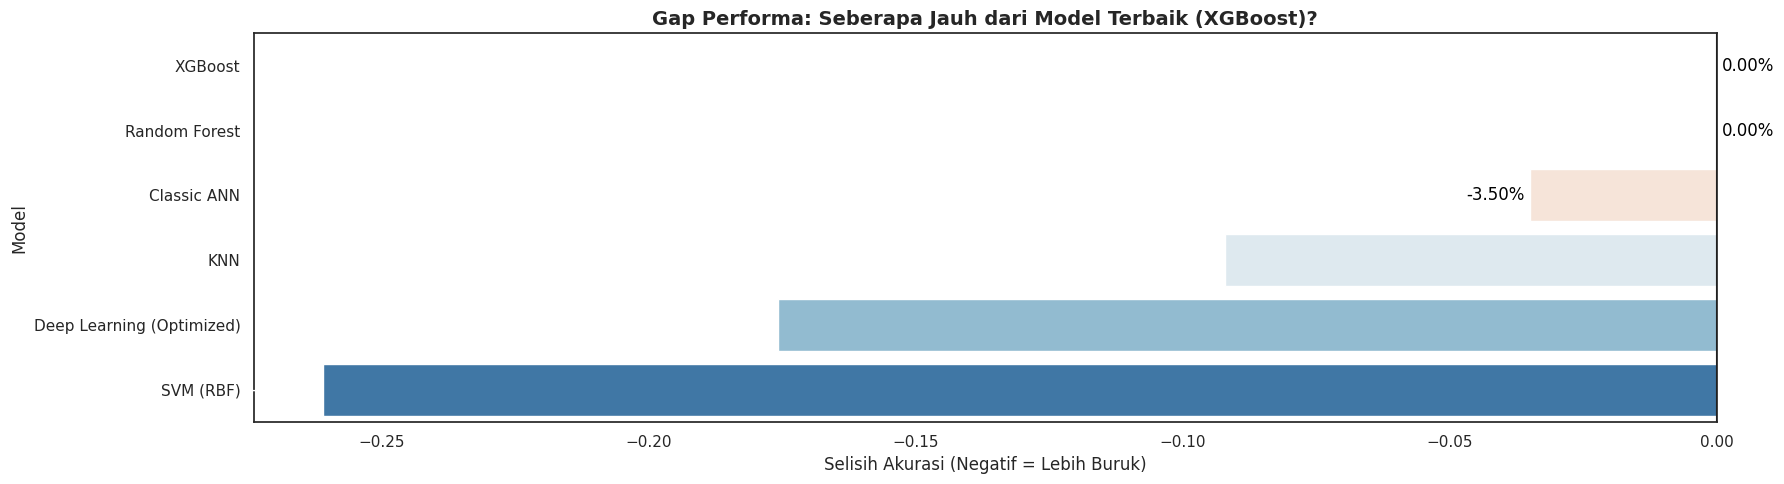


[VISUALISASI 2] Membuat Detail Kehandalan per Gangguan...


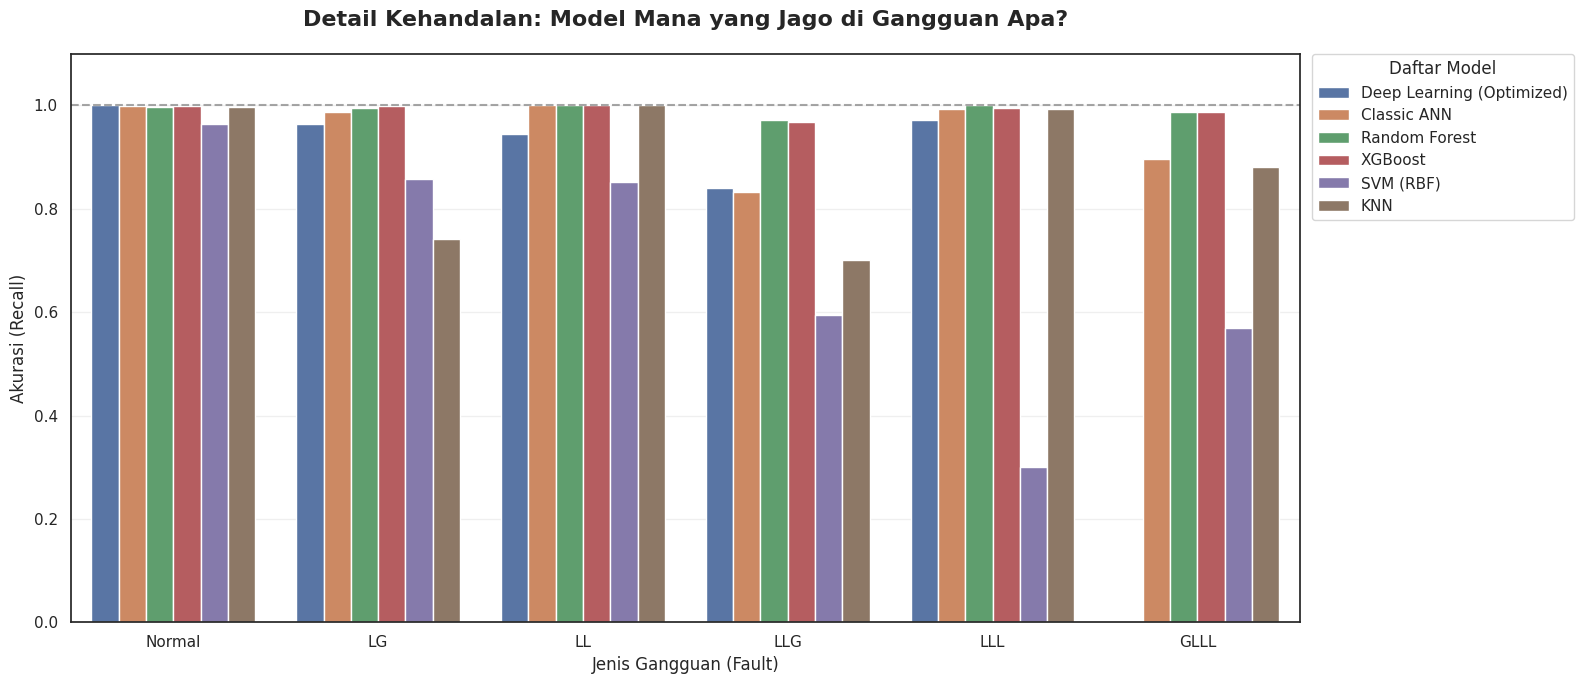


[VISUALISASI 3] Menghitung Ranking & Heatmap...


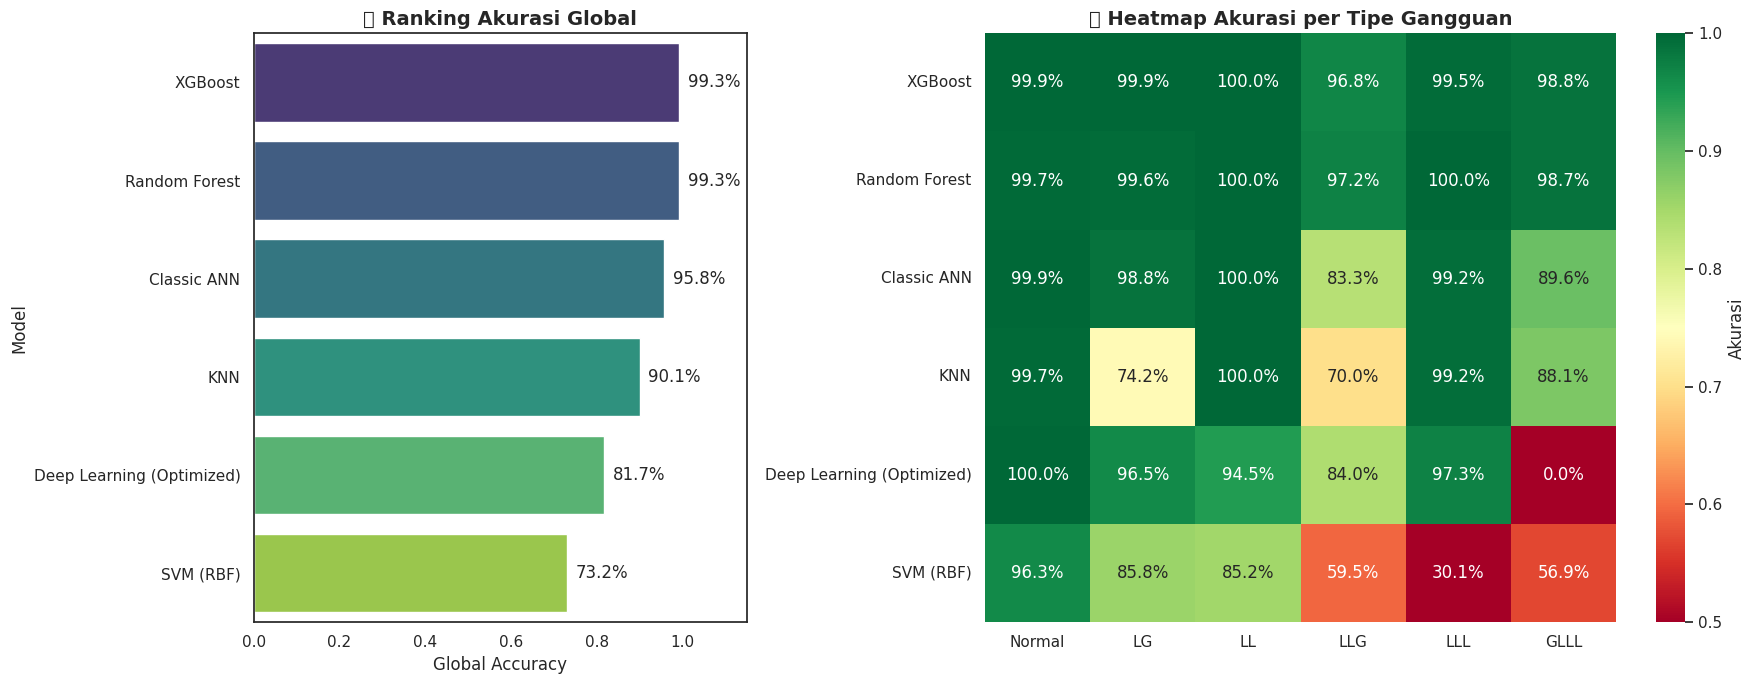


[VISUALISASI 4] Membuat ROC Curve...


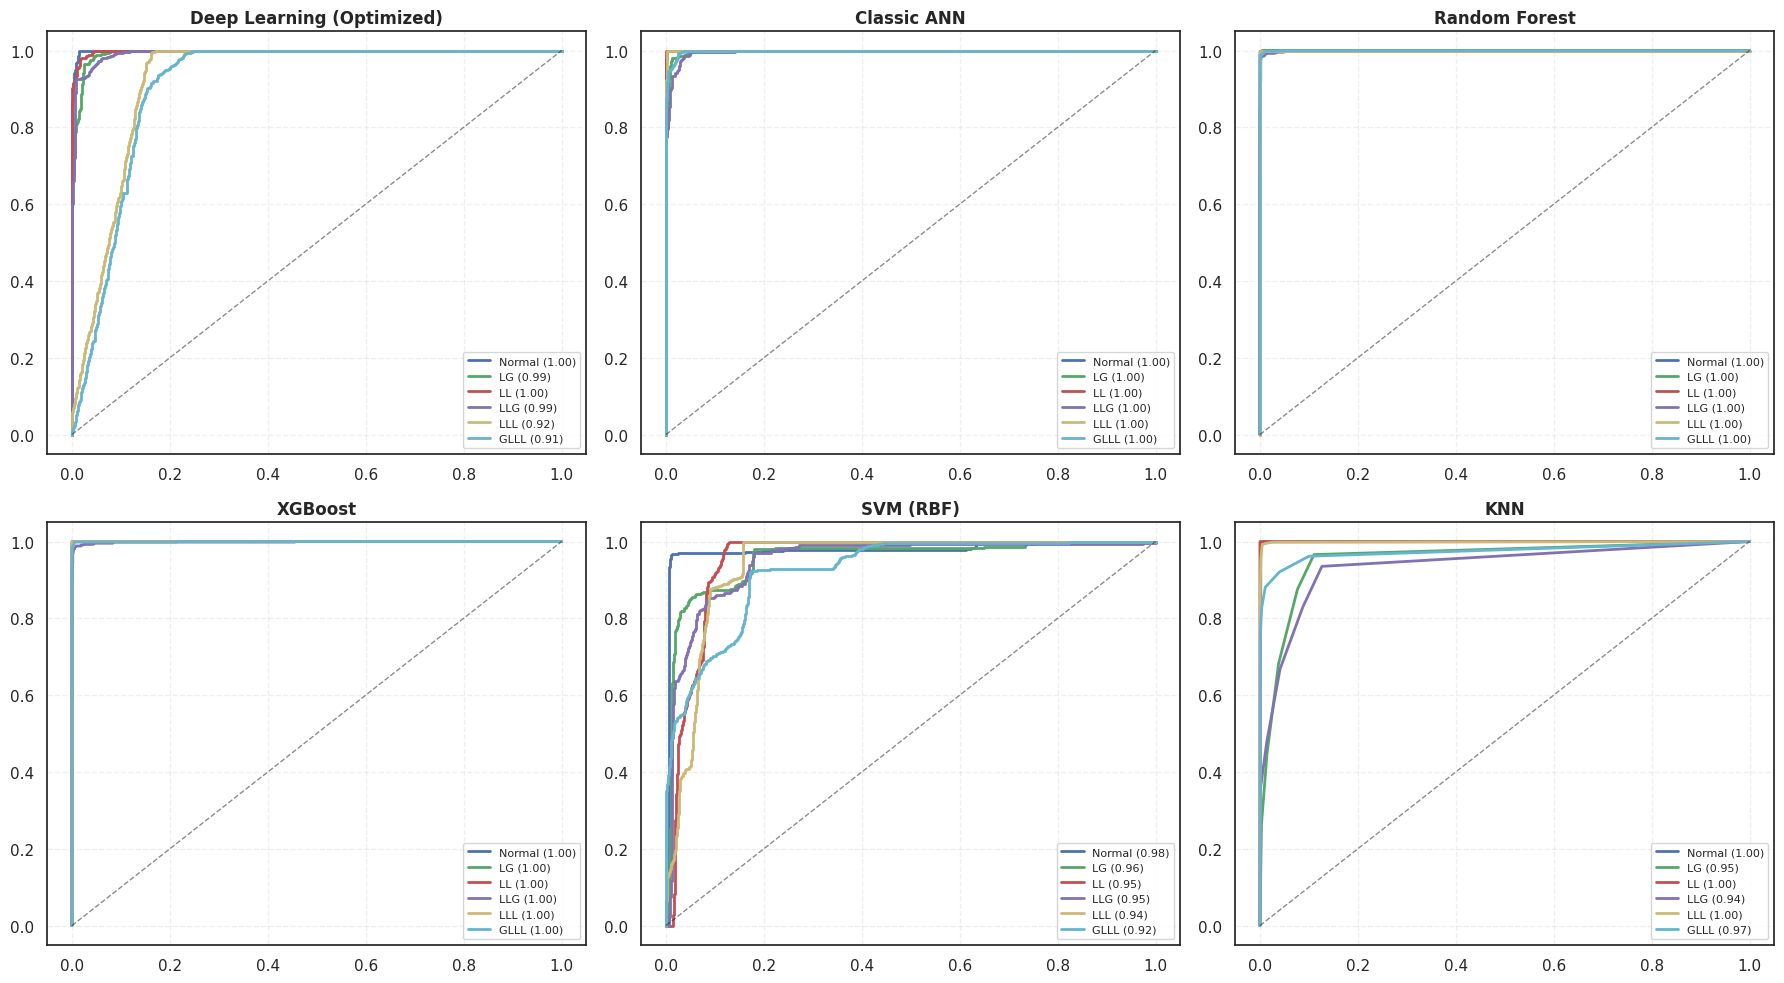


🏆 Model Pemenang: XGBoost
Project Selesai.


In [16]:
# ==============================================================================
# 6. ADVANCED VISUALIZER: EVALUASI & KOMPARASI (FINAL FIXED)
# ==============================================================================
class AdvancedVisualizer:
    def __init__(self):
        self.labels_map = {0:'Normal', 1:'LG', 2:'LL', 3:'LLG', 4:'LLL', 5:'GLLL'}

        # Palet Warna Professional (Soft/Muted) -> KHUSUS UNTUK BAR CHART
        self.prof_palette = {
            'Deep Learning (Optimized)': '#4C72B0', # Soft Blue
            'Classic ANN':               '#DD8452', # Soft Orange
            'Random Forest':             '#55A868', # Soft Green
            'XGBoost':                   '#C44E52', # Soft Red
            'SVM (RBF)':                 '#8172B3', # Soft Purple
            'KNN':                       '#937860'  # Soft Brown
        }

    # --- FITUR 1: DATA CLASSIFICATION REPORT (TEKS) ---
    def show_classification_reports(self, estimators, X_test, y_test):
        print("\n" + "="*100)
        print(f"{'TABEL CLASSIFICATION REPORT DETIL':^100}")
        print("="*100)
        target_names = [self.labels_map[i] for i in range(6)]
        for name, model in estimators.items():
            y_pred = model.predict(X_test)
            print(f"\n>> MODEL: {name.upper()}")
            print("-" * 60)
            print(classification_report(y_test, y_pred, target_names=target_names))
            print("-" * 60)

    # --- FITUR 2: DELTA ACCURACY COMPARISON ---
    def plot_delta_comparison(self, estimators, X_test, y_test):
        print("\n[VISUALISASI 1] Membuat Grafik Delta Accuracy...")
        scores = []
        for name, model in estimators.items():
            acc = accuracy_score(y_test, model.predict(X_test))
            scores.append({'Model': name, 'Accuracy': acc})

        df = pd.DataFrame(scores).sort_values(by='Accuracy', ascending=False)
        best_acc = df.iloc[0]['Accuracy']
        best_model = df.iloc[0]['Model']
        df['Delta'] = df['Accuracy'] - best_acc

        plt.figure(figsize=(18, 5))
        sns.barplot(data=df, x='Delta', y='Model', palette='RdBu')
        plt.title(f"Gap Performa: Seberapa Jauh dari Model Terbaik ({best_model})?", fontsize=14, fontweight='bold')
        plt.axvline(0, color='black', linestyle='-')
        plt.xlabel("Selisih Akurasi (Negatif = Lebih Buruk)")

        for i, val in enumerate(df['Delta']):
            text_color = 'black' if val > -0.05 else 'white'
            offset = 0.001 if val == 0 else -0.001
            plt.text(val + offset, i, f"{val:.2%}", va='center', ha='left' if val==0 else 'right', color=text_color)
        plt.tight_layout(); plt.show()

    # --- FITUR 3: VISUALISASI PERBANDINGAN PER GANGGUAN (GROUPED BAR) ---
    def plot_fault_reliability_comparison(self, estimators, X_test, y_test):
        print("\n[VISUALISASI 2] Membuat Detail Kehandalan per Gangguan...")
        data = []

        for name, model in estimators.items():
            y_pred = model.predict(X_test)
            cm = confusion_matrix(y_test, y_pred)

            # Menghitung Akurasi per Kelas
            with np.errstate(divide='ignore', invalid='ignore'):
                per_class_acc = cm.diagonal() / cm.sum(axis=1)

            per_class_acc = np.nan_to_num(per_class_acc)

            for idx, acc in enumerate(per_class_acc):
                data.append({
                    'Model': name,
                    'Fault Type': self.labels_map.get(idx, f"Class {idx}"),
                    'Accuracy': acc
                })

        df = pd.DataFrame(data)

        # Plotting dengan Palet Professional
        plt.figure(figsize=(16, 7))
        ax = sns.barplot(data=df, x='Fault Type', y='Accuracy', hue='Model', palette=self.prof_palette)

        plt.title("Detail Kehandalan: Model Mana yang Jago di Gangguan Apa?", fontsize=16, fontweight='bold', pad=20)
        plt.ylabel("Akurasi (Recall)", fontsize=12)
        plt.xlabel("Jenis Gangguan (Fault)", fontsize=12)
        plt.ylim(0, 1.1)
        plt.axhline(1.0, color='gray', linestyle='--', alpha=0.7)
        plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0, title="Daftar Model")
        plt.grid(axis='y', linestyle='-', alpha=0.3)
        plt.tight_layout()
        plt.show()

    # --- FITUR 4: RANKING & HEATMAP (UPDATED COLOR) ---
    def plot_performance_dashboard(self, estimators, X_test, y_test):
        global_scores = []
        heatmap_data = []
        print("\n[VISUALISASI 3] Menghitung Ranking & Heatmap...")
        for name, model in estimators.items():
            y_pred = model.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            global_scores.append({'Model': name, 'Global Accuracy': acc})

            cm = confusion_matrix(y_test, y_pred)
            with np.errstate(divide='ignore', invalid='ignore'):
                per_class = cm.diagonal() / cm.sum(axis=1)
            per_class = np.nan_to_num(per_class)

            row = {'Model': name}
            for idx, score in enumerate(per_class): row[self.labels_map[idx]] = score
            heatmap_data.append(row)

        df_global = pd.DataFrame(global_scores).sort_values(by='Global Accuracy', ascending=False)
        df_heatmap = pd.DataFrame(heatmap_data).set_index('Model').reindex(df_global['Model'])

        fig, axes = plt.subplots(1, 2, figsize=(18, 7), gridspec_kw={'width_ratios': [1, 1.6]})

        # Ranking Plot (Bar Chart Kiri)
        sns.barplot(data=df_global, x='Global Accuracy', y='Model', ax=axes[0], palette='viridis')
        axes[0].set_title('🏆 Ranking Akurasi Global', fontsize=14, fontweight='bold')
        axes[0].set_xlim(0, 1.15)
        for i, v in enumerate(df_global['Global Accuracy']): axes[0].text(v+0.02, i, f"{v*100:.1f}%", va='center')

        # Heatmap (Kanan) -> KEMBALI KE STANDARD GRADIENT (RdYlGn)
        # Merah = Buruk, Kuning = Sedang, Hijau = Bagus
        sns.heatmap(df_heatmap, annot=True, cmap="RdYlGn", fmt=".1%", ax=axes[1],
                    vmin=0.5, vmax=1.0, cbar_kws={'label': 'Akurasi'})

        axes[1].set_title('🔍 Heatmap Akurasi per Tipe Gangguan', fontsize=14, fontweight='bold')
        axes[1].set_ylabel('')
        plt.tight_layout(); plt.show()
        return df_global

    # --- FITUR 5: ROC CURVES ---
    def plot_roc_curves(self, estimators, X_test, y_test):
        n_classes = 6
        y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
        print("\n[VISUALISASI 4] Membuat ROC Curve...")
        rows = math.ceil(len(estimators) / 3)
        fig, axes = plt.subplots(rows, 3, figsize=(18, 5 * rows))
        axes = axes.flatten()

        for idx, (name, model) in enumerate(estimators.items()):
            ax = axes[idx]
            if hasattr(model, "predict_proba"): y_score = model.predict_proba(X_test)
            elif hasattr(model, "decision_function"): y_score = model.decision_function(X_test)
            else: continue

            # Warna curve ROC
            curve_colors = cycle(['#4C72B0', '#55A868', '#C44E52', '#8172B3', '#CCB974', '#64B5CD'])

            for i, color in zip(range(n_classes), curve_colors):
                score_col = y_score[:, i] if y_score.ndim > 1 else y_score
                fpr, tpr, _ = roc_curve(y_test_bin[:, i], score_col)
                roc_auc = auc(fpr, tpr)
                ax.plot(fpr, tpr, color=color, lw=2, label=f'{self.labels_map[i]} ({roc_auc:.2f})')

            ax.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5)
            ax.set_title(f'{name}', fontweight='bold'); ax.legend(loc="lower right", fontsize=8)
            ax.grid(True, linestyle='--', alpha=0.3)

        for j in range(idx + 1, len(axes)): fig.delaxes(axes[j])
        plt.tight_layout(); plt.show()

# --- EKSEKUSI VISUALISASI AKHIR ---
viz = AdvancedVisualizer()

# A. Text Report
viz.show_classification_reports(estimators, X_test, y_test)

# B. Grafik Komparasi
viz.plot_delta_comparison(estimators, X_test, y_test)

# C. Grafik Grouped Bar (Warna Professional)
viz.plot_fault_reliability_comparison(estimators, X_test, y_test)

# D. Dashboard Heatmap (Warna Standard RdYlGn) & ROC
df_ranking = viz.plot_performance_dashboard(estimators, X_test, y_test)
viz.plot_roc_curves(estimators, X_test, y_test)

# E. Simpan Model Terbaik
winner = df_ranking.iloc[0]['Model']
print(f"\n🏆 Model Pemenang: {winner}")

if "Deep Learning" in winner: estimators[winner].model.save('best_model.keras')
else:
    with open('best_model.pkl', 'wb') as f: pickle.dump(estimators[winner], f)
print("Project Selesai.")